In [26]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

In [27]:
#tf.config.set_visible_devices([], 'GPU')

In [28]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [29]:
len(words)

32033

In [30]:
chars = sorted(list(set(''.join(words))))

stoi = {s: i for i, s in enumerate(('.', *chars))}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [31]:
block_size = 3

def build_dataset(words, block_size):
    X, Y = [], []

    for w in words:
        #print(w)
        context = [stoi['.']] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', ch)
            context = context[1:] + [ix]

    return tf.convert_to_tensor(X), tf.convert_to_tensor(Y)


n1, n2 = int(len(words)*0.8), int(len(words)*0.9)

random.seed(42)
random.shuffle(words)

X_train, Y_train = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_test, Y_test = build_dataset(words[n2:], block_size)

In [32]:
n_embd = 10
n_hidden = 200

tf.random.set_seed(314159)
C = tf.Variable(tf.random.normal((vocab_size, n_embd)), name='C')
W1 = tf.Variable(tf.random.normal((n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size)**0.5), name='W1')
W2 = tf.Variable(tf.random.normal((n_hidden, vocab_size)) * 0.01, name='W2')
b2 = tf.Variable(tf.zeros(vocab_size, dtype=tf.float32), name='b2')

bn_gain = tf.Variable(tf.ones((1, n_hidden), dtype=tf.float32), name='bn_gain')
bn_bias = tf.Variable(tf.zeros((1, n_hidden), dtype=tf.float32), name='bn_bias')
bn_mean_running = tf.Variable(tf.zeros((1, n_hidden), dtype=tf.float32), trainable=False, name='bn_mean')
bn_std_running = tf.Variable(tf.ones((1, n_hidden), dtype=tf.float32), trainable=False, name='bn_std')

parameters = {p.name: p for p in [C, W1, bn_gain, bn_bias, W2, b2]}

print(f'params: {sum(map(tf.size, parameters.values())).numpy()}')

print(list(parameters.keys()))

def eval(X, train=False):
    emb = tf.gather(C, X)
    embcat = tf.reshape(emb, (-1, n_embd * block_size))
    hpreact = embcat @ W1

    if train:
        bn_mean = tf.math.reduce_mean(hpreact, 0, keepdims=True)
        bn_std = tf.math.reduce_std(hpreact, 0, keepdims=True)
        bn_mean_running.assign(bn_mean_running*0.999 + bn_mean*0.001)
        bn_std_running.assign(bn_std_running*0.999 + bn_std*0.001)
    else:
        bn_mean = bn_mean_running
        bn_std = bn_std_running

    hpreact = bn_gain*(hpreact - bn_mean)/bn_std + bn_bias
    h = tf.math.tanh(hpreact)
    logits = (h @ W2 + b2)
    return {
        'logits': logits,
        'h': h,
        'hpreact': hpreact
    }

    
@tf.function
def eval_loss(X, Y, train=False):
    output = eval(X, train)
    loss = tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(Y, output['logits'], from_logits=True))
    return loss, output

params: 12097
['C:0', 'W1:0', 'bn_gain:0', 'bn_bias:0', 'W2:0', 'b2:0']


In [33]:
lossi = []

In [34]:
max_steps = 100000
batch_size = 32
learning_rate = tf.Variable(0.01, trainable=False)


def apply_gradient(param, grad):
    if isinstance(grad, tf.IndexedSlices):
        sub_value = tf.IndexedSlices(grad.values * learning_rate, grad.indices)
        param.scatter_sub(sub_value)
    else:
        param.assign_sub(learning_rate*grad)

 
@tf.function
def train_step(X, Y):
    with tf.GradientTape() as tape:
        loss, output = eval_loss(X, Y, train=True)
    
    grads = tape.gradient(loss, parameters)
    for p, dl_dp in zip(parameters.values(), grads.values()):
        apply_gradient(p, dl_dp)
     
    return loss, output, grads


for i in range(max_steps):
    batch_ix = tf.random.uniform(shape=(batch_size,), minval=0, maxval=X_train.shape[0], dtype=tf.int32)
    X_batch = tf.gather(X_train, batch_ix)
    Y_batch = tf.gather(Y_train, batch_ix)

    learning_rate.assign(0.1 if i < 50000 else 0.01)
    loss, output, grads = train_step(X_batch, Y_batch)
    
    lossi.append(np.log(loss))

    if i % 10000 == 0:
        train_loss = eval_loss(X_train, Y_train)[0].numpy()
        print(f'{i:7d}/{max_steps:7d}: {train_loss:.4f}')

    #break


print(f'train = {eval_loss(X_train, Y_train)[0].numpy()}, dev = {eval_loss(X_dev, Y_dev)[0].numpy()}')



      0/ 100000: 3.2741
  10000/ 100000: 2.2696
  20000/ 100000: 2.2096
  30000/ 100000: 2.1832
  40000/ 100000: 2.1741
  50000/ 100000: 2.1708
  60000/ 100000: 2.1029
  70000/ 100000: 2.1001
  80000/ 100000: 2.0971
  90000/ 100000: 2.0951
train = 2.094252109527588, dev = 2.128375291824341


In [35]:
# 0: train = 2.1723361015319824, dev = 2.1950716972351074
# 1: train = 2.0964858531951904, dev = 2.1465535163879395
# 2: train = 2.064552068710327,  dev = 2.1139414310455322
# 3: train = 2.094252109527588,  dev = 2.128375291824341
# 3: train = 2.0673418045043945, dev = 2.109072685241699
print(f'train = {eval_loss(X_train, Y_train)[0].numpy()}, dev = {eval_loss(X_dev, Y_dev)[0].numpy()}')

train = 2.094252109527588, dev = 2.128375291824341


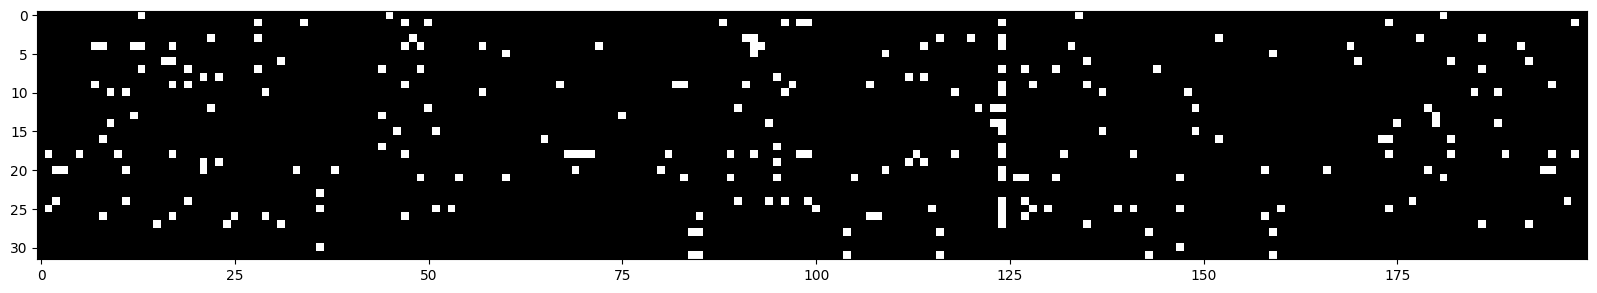

In [36]:
plt.figure(figsize=(20, 10))
plt.imshow(np.abs(output['h'].numpy()) > 0.99,  cmap=plt.cm.gray)

In [37]:
output['hpreact'].shape, tf.math.reduce_mean(output['hpreact'], 0, keepdims=True).shape

(TensorShape([32, 200]), TensorShape([1, 200]))

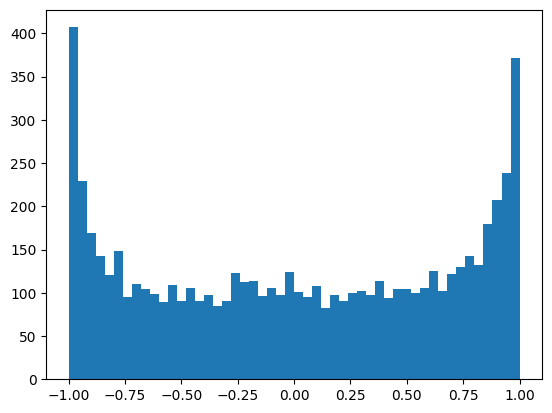

In [38]:
plt.hist(tf.reshape(output['h'], (-1,)).numpy(), bins=50);


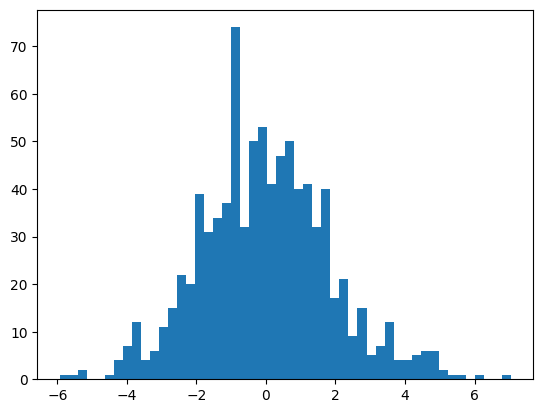

In [39]:
plt.hist(tf.reshape(output['logits'], (-1,)).numpy(), bins=50);

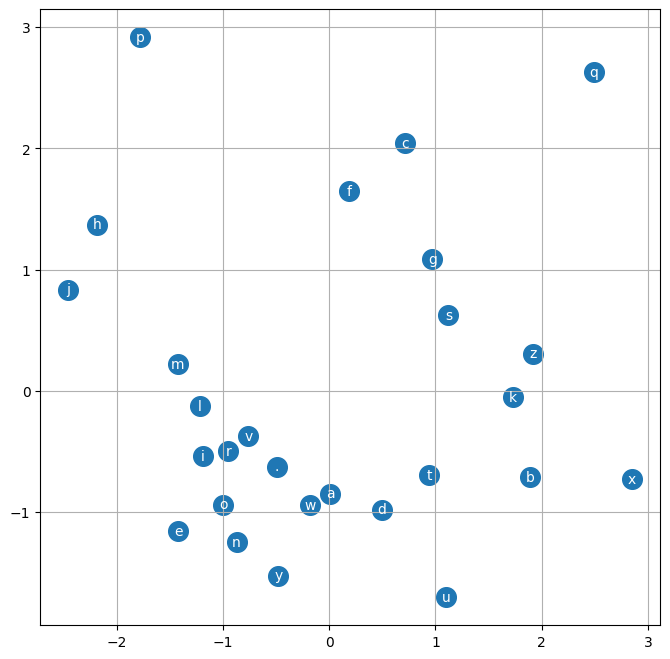

In [40]:
emb_2d = PCA(n_components=2).fit_transform(C.numpy())

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=200)
for i in range(C.shape[0]):
    plt.text(emb_2d[i,0], emb_2d[i,1], itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [41]:
# batch generate examples

gen_batch_size = 10
gen_target = 20

gen_count = 0
start_context = tf.zeros((gen_batch_size, block_size), dtype=tf.int32)
context = start_context
out = [[] for _ in range(gen_batch_size)]

while gen_count < gen_target:
    output = eval(context)
    next_one_hot = tfp.distributions.Multinomial(1, logits=output['logits']).sample()
    next_ix = tf.argmax(next_one_hot, axis=1, output_type=tf.int32)

    reset = []
    for con_i, (o, i) in enumerate(zip(out, next_ix)):
        o.append(itos[i.numpy()])
        if i == 0:
            print(''.join(o))
            o.clear()
            gen_count += 1
            reset.append([con_i])


    context = tf.concat([context[:, 1:], tf.reshape(next_ix, (-1, 1))], axis=1)

    # context might have rows like [5, 10, 0] which will cause the nn to produce
    # nonsence, 
    if len(reset) > 0:
        context = tf.tensor_scatter_nd_update(
            context,
            reset, 
            start_context[:len(reset), :]
        )

dem.
gen.
sha.
ura.
lune.
dany.
hephan.
chylia.
lin.
akfonta.
maddriel.
anna.
aadie.
gan.
amiah.
frani.
miko.
melam.
dadorvmnne.
den.
joyalonan.
luylah.
